In [1]:
import numpy
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.svm import SVR
from numpy import array
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from numpy.lib.stride_tricks import as_strided as ast
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
from numpy.lib.stride_tricks import as_strided as ast
import itertools
import operator
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras import regularizers
        
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import pickle

import datetime

from keras.layers import CuDNNLSTM

Using TensorFlow backend.
/raid/home/labuseraber/environment/testEnvironment/.conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/raid/home/labuseraber/environment/testEnvironment/.conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/raid/home/labuseraber/environment/testEnvironment/.conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  

In [2]:
import matplotlib
import matplotlib.pyplot as plt

def evaluateWeightedPerformance(cm):
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    summ = np.sum(cm, axis=1)
    TN = []
    precision =[]
    FMeaure = []
    recall = []
    accuracy = []
    for i in range(len(TP)):
        temp = np.delete(cm, i, 0)    # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))
    message = "TP = " + str(TP)+"\n"
    print(message)
    message = "FP = " + str(FP)+"\n"
    print(message)
    message = "FN = " + str(FN)+"\n"
    print(message)
    message = "TN = " + str(TN)+"\n"
    print(message)
    for i in range(0, len(TP)):
        if(TP[i] == 0 and FP[i] == 0):
            precision.append(0)
            FMeaure.append(0)
            recall.append(TP[i]/(TP[i]+FN[i]))
            accuracy.append((TN[i]+TP[i])/(TN[i]+FP[i]+FN[i]+TP[i]))
        else:
            precision.append(TP[i]/(TP[i]+FP[i]))
            recall.append(TP[i]/(TP[i]+FN[i]))
            FMeaure.append(2*(precision[i]*recall[i])/(recall[i]+precision[i]))
            accuracy.append((TN[i]+TP[i])/(TN[i]+FP[i]+FN[i]+TP[i]))
##    message = "precision "+str(precision)+"\n"
##    print(message)
##    message = "recall "+str(recall)+"\n"
##    print(message)
##    message = "FMeaure "+str(FMeaure)+"\n"
##    print(message)
##    message = "accuracy "+str(accuracy)+"\n"
##    print(message)
    sumsum = 0
    weightedaccuracy = 0
    weightedFMeaure= 0
    weightedrecall = 0
    weightedprecision = 0
    for i in range(0, len(precision)):
        weightedprecision = weightedprecision+precision[i]*summ[i]
        weightedrecall = weightedrecall+recall[i]*summ[i]
        weightedFMeaure = weightedFMeaure+FMeaure[i]*summ[i]
        weightedaccuracy = weightedaccuracy+accuracy[i]*summ[i]
        sumsum = summ[i]+sumsum
    weightedprecision = weightedprecision/sumsum
    weightedrecall = weightedrecall/sumsum
    weightedFMeaure = weightedFMeaure/sumsum
    weightedaccuracy = weightedaccuracy/sumsum
    precision = np.average(precision)
    recall = np.average(recall)
    FMeaure = np.average(FMeaure)
    accuracy = np.average(accuracy)
##    message = "Average precision "+str(precision)+"\n"
##    print(message)
##    message = "Average recall "+str(recall)+"\n"
##    print(message)
##    message = "Average FMeaure "+str(FMeaure)+"\n"
##    print(message)
##    message = "Average accuracy "+str(accuracy)+"\n"
##    print(message)
    message = "Weighted precision "+str(weightedprecision)+"\n"
    print(message)
    message = "Weighted recall "+str(weightedrecall)+"\n"
    print(message)
    message = "Weighted FMeaure "+str(weightedFMeaure)+"\n"
    print(message)
    message = "Weighted accuracy "+str(weightedaccuracy)+"\n"
    print(message)
    
    
def norm_shape(shape):
    '''
    Normalize numpy array shapes so they're always expressed as a tuple,
    even for one-dimensional shapes.
    Parameters
        shape - an int, or a tuple of ints
    Returns
        a shape tuple
    '''
    try:
        i = int(shape)
        return (i,)
    except TypeError:
        # shape was not a number
        pass

    try:
        t = tuple(shape)
        return t
    except TypeError:
        # shape was not iterable
        pass

    raise TypeError('shape must be an int, or a tuple of ints')

def sliding_window(a,ws,ss = None,flatten = True):
    '''
    Return a sliding window over a in any number of dimensions
    Parameters:
        a  - an n-dimensional numpy array
        ws - an int (a is 1D) or tuple (a is 2D or greater) representing the size
             of each dimension of the window
        ss - an int (a is 1D) or tuple (a is 2D or greater) representing the
             amount to slide the window in each dimension. If not specified, it
             defaults to ws.
        flatten - if True, all slices are flattened, otherwise, there is an
                  extra dimension for each dimension of the input.
    Returns
        an array containing each n-dimensional window from a
    '''

    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)
    print(str(ws))
    print(str(ss))

    # convert ws, ss, and a.shape to numpy arrays so that we can do math in every
    # dimension at once.
    ws = np.array(ws)
    ss = np.array(ss)
    shape = np.array(a.shape)
    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shape),len(ws),len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(\
        'a.shape, ws and ss must all have the same length. They were %s' % str(ls))

    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shape):
        raise ValueError(\
        'ws cannot be larger than a in any dimension.\a.shape was %s and ws was %s' % (str(a.shape),str(ws)))

    # how many slices will there be in each dimension?
    newshape = norm_shape(((shape - ws) // ss) + 1)
    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)
    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    strided = ast(a,shape = newshape,strides = newstrides)
    if not flatten:
        return strided

    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.product(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    return strided.reshape(dim)

def opp_sliding_window(data_x, data_y, ws, ss, flatten=True):
    data_x = sliding_window(data_x, (ws, data_x.shape[1]), (ss, 1), flatten)#(data_x, (ws, data_x.shape[1]), (ss, 1), flatten)
    #data_x = sliding_window(data_x,ws, ss, flatten)
    # This Command will assign the last sample class to be the window class
    # data_y = np.asarray([[i[-1]] for i in sliding_window(data_y,ws,ss)])
    # This Commands will assign the most dominant class to be the window class
    windows = sliding_window(data_y, ws, ss, flatten)
    mostDom = []
    for i in windows:
        mostDom.append(most_common(i))
    data_y = np.asarray(mostDom)
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

def most_common(L):
    # get an iterable of (item, iterable) pairs
    SL = sorted((x, i) for i, x in enumerate(L))
    # print 'SL:', SL
    groups = itertools.groupby(SL, key=operator.itemgetter(0))

    # auxiliary function to get "quality" for an item
    def _auxfun(g):
        item, iterable = g
        count = 0
        min_index = len(L)
        for _, where in iterable:
            count += 1
            min_index = min(min_index, where)
        # print 'item %r, count %r, minind %r' % (item, count, min_index)
        return count, -min_index

    # pick the highest-count/earliest item
    return max(groups, key=_auxfun)[0]

# load the dataset, returns train and test X and y elements
def load_dataset(modelName):
        # load dataset
        #dataset = open("OnlyActivities.csv", "r")
        dataset = open("oa.csv", "r")
        
        lines = dataset.readlines()
        dataLength= len(lines)
        number = 0
        splitRateTrainTest = 0.7
        # splitRateTrainTest = 1.0
        trainSize = round(dataLength*splitRateTrainTest)
        testSize = dataLength - trainSize
        for x in lines:
            if(number == 0):
                partsV0 = x.split('\n', 1)
                featuresV0 = partsV0[0].split(',')
                NumberofFeatures= len(featuresV0)
                number = number +1
        data = [[0 for k in range (NumberofFeatures)] for l in range (dataLength)]
        re = 0
        for x in lines:
            parts = x.split('\n', 1)
            features = parts[0].split(',')
            data[re] = features
            re = re+1
        data = array(data)
        datafeature = data[:, 2:-1]
        datalabel = data[:, -1]
        WindowSize= 128
        Overlapp= 64
        if(modelName == "CNN-LSTM" or modelName == "CNN" or modelName == "LSTM"):
            data, label = opp_sliding_window(datafeature, datalabel, WindowSize, Overlapp)
        else:
            data = datafeature
            label = datalabel
        datasizeAfterWindowing= len(data)
        testSize = int(0.3*datasizeAfterWindowing)
        print(trainSize)
        trainX = data[0:trainSize, :]
        trainy = label[0:trainSize]
        testX = data[0:trainSize, :]#[trainSize+1:(datasizeAfterWindowing),:]
        testy = label[0:trainSize]#label[trainSize+1:(datasizeAfterWindowing)]
        trainy = to_categorical(trainy, num_classes=17)
        testy = to_categorical(testy, num_classes=17)
        return trainX, trainy, testX, testy

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [3]:
modelName = "CNN-LSTM"

trainX, trainy, testX, testy = load_dataset(modelName)

scores = list()
precisions = list()
recalls = list()
f1s = list()

(128, 235)
(64, 1)
(128,)
(64,)
232065


In [4]:
verbose = 1 #0, 1000, 60

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
print("n_timesteps = ")
print(n_timesteps)
print("n_features = ")
print(n_features)
print("n_outputs = ")
print(n_outputs)
# reshape data into time steps of sub-sequences
#n_steps, n_length = 4, 32
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.4)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(CuDNNLSTM(units=200, return_sequences=True))
model.add(CuDNNLSTM(units=100, return_sequences=True))
model.add(CuDNNLSTM(units=100))
model.add(Dropout(0.4))
#model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="./weightsCNNLSTMAct08012023.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                  patience=50, min_lr=0.0001)

r = datetime.datetime.now()
print (datetime.datetime.now())

# fit network
history = model.fit(trainX, trainy, epochs=500, batch_size=10, verbose=verbose, validation_split=0.2, callbacks = [reduce_lr,checkpoint])

print (r)
print (datetime.datetime.now())

print ("Saving History Model")

model.summary()

n_timesteps = 
128
n_features = 
235
n_outputs = 
17

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 30, 64)      45184     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 28, 32)      6176      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 26, 16)      1552      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 26, 16)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 13, 16)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 208)         0         
_________________________________________________________________


2023-01-08 16:24:07.051824: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-01-08 16:24:07.078464: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2194955000 Hz
2023-01-08 16:24:07.079823: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563da7f17860 executing computations on platform Host. Devices:
2023-01-08 16:24:07.079844: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2023-01-08 16:24:07.081962: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2023-01-08 16:24:07.708255: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563da00fc820 executing computations on platform CUDA. Devices:
2023-01-08 16:24:07.708292: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Tesla V100-SXM2-32GB,


Train on 4143 samples, validate on 1036 samples
Epoch 1/500


2023-01-08 16:24:10.515927: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcublas.so.10.0
2023-01-08 16:24:10.915814: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudnn.so.7


4143/4143 [==============================] - 6s 1ms/step - loss: 1.3799 - accuracy: 0.6894 - val_loss: 1.3136 - val_accuracy: 0.7162

Epoch 00001: val_accuracy improved from -inf to 0.71622, saving model to ./weightsCNNLSTMAct08012023.best.hdf5
Epoch 2/500
4143/4143 [==============================] - 3s 843us/step - loss: 1.3078 - accuracy: 0.6910 - val_loss: 1.3323 - val_accuracy: 0.7162

Epoch 00002: val_accuracy did not improve from 0.71622
Epoch 3/500
4143/4143 [==============================] - 4s 850us/step - loss: 1.3084 - accuracy: 0.6910 - val_loss: 1.3146 - val_accuracy: 0.7162

Epoch 00003: val_accuracy did not improve from 0.71622
Epoch 4/500
4143/4143 [==============================] - 4s 850us/step - loss: 1.3034 - accuracy: 0.6910 - val_loss: 1.3237 - val_accuracy: 0.7162

Epoch 00004: val_accuracy did not improve from 0.71622
Epoch 5/500
4143/4143 [==============================] - 4s 863us/step - loss: 1.2976 - accuracy: 0.6910 - val_loss: 1.2994 - val_accuracy: 0.7162

In [5]:
with open('./trainHistoryAct08012023', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print ("History Model Saved")

History Model Saved


In [6]:
predictions = model.predict(testX)
prediction = []
testyindex = []
outputconfusionMatrixfile = open("confusionActivities19012022.txt","w")
predictionindex = []
for i in range(0, len(predictions)):
        prediction.append(0)
        predictionindex.append(0)
        testyindex.append(0)

for i in range(0, len(predictions)):
        prediction[i]= np.round(predictions[i], 2)
        for j in range(0, len(predictions[0])):
                if(predictions[i][j] == max(predictions[i])):
                        predictionindex[i] = j
                if(testy[i][j] == max(testy[i])):
                        testyindex[i] = j
print("len(predictionindex)= ", str(len(predictionindex)))
print("len(testyindex) = ", str(len(testyindex)))
filewriter = open("CNN-LSTM-O4H-Activity19012022-Output.txt", "w")
for i in range(0, len(testyindex)):
    message = str(i)+ " "+ str(testyindex[i])+" "+ str(predictionindex[i])+"\n"
    filewriter.write(message)
filewriter.close()
np.set_printoptions(threshold=np.inf)
cm = confusion_matrix(testyindex, predictionindex, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
evaluateWeightedPerformance(cm)
with open("confusionOnlyActivities19012022.txt", 'w') as f:
        f.write(np.array2string(cm, separator=', '))

len(predictionindex)=  5179
len(testyindex) =  5179
TP = [  15    1  122   41    1  262   15 3519   18   97   61   44    8    7
  115  107    4]

FP = [  4   0  33  10   0  72   2 517   3  11  12  11   1   0  36  30   0]

FN = [ 16   0  60  31   0 170  14  86   9  35  64  30   3   3 105  90  26]

TN = [5144, 5178, 4964, 5097, 5178, 4675, 5148, 1057, 5149, 5036, 5042, 5094, 5167, 5169, 4923, 4952, 5149]

Weighted precision 0.8518670063927997

Weighted recall 0.8567290982815216

Weighted FMeaure 0.8450411704027357

Weighted accuracy 0.9114994641906631



In [7]:
print("Confusion matrix:\n", cm)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testyindex, predictionindex)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testyindex, predictionindex, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testyindex, predictionindex, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testyindex, predictionindex, average='weighted')
print('F1 score: %f' % f1)
outputconfusionMatrixfile.close()
    #return accuracy, precision, recall, f1

Confusion matrix:
 [[  15    0    2    1    0    2    0   10    0    0    0    1    0    0
     0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0  122    0    0    9    0   38    0    3    2    0    1    0
     5    2    0]
 [   0    0    4   41    0    4    0   19    0    0    1    0    0    0
     2    1    0]
 [   0    0    0    0    1    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   1    0    3    2    0  262    0  149    2    3    1    2    0    0
     5    2    0]
 [   0    0    0    0    0    1   15   11    0    2    0    0    0    0
     0    0    0]
 [   1    0    6    1    0   28    2 3519    1    1    7    2    0    0
    18   19    0]
 [   0    0    1    0    0    2    0    5   18    0    0    0    0    0
     0    1    0]
 [   2    0    4    3    0    4    0   15    0   97    1    4    0    0
     0    2    0]
 [   0    0    0    0    0    3    0   58    0    0   61    1    0    0
     1   

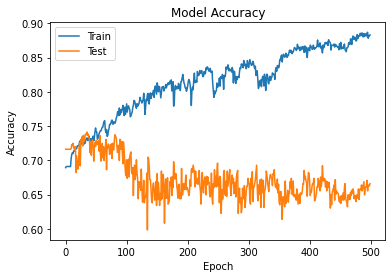

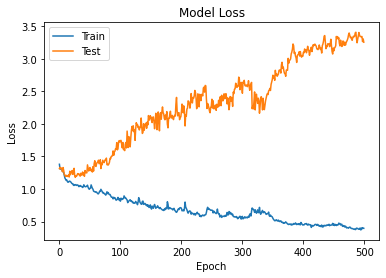

In [8]:
# ACC = 0.98269
import matplotlib.pyplot as plt
%matplotlib inline  


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
from numpy import savetxt
from numpy import argmax

LABELSActivity = ["Entering", "Going_up", "Showering", "Using_the_sink", "Going_down", "Watching_TV", "Using_the_toilet", "Computing",
                  "Preparing", "Cooking", "Eating", "Washing_the_dishes", "Cleaning", "Dressing", "Reading", "Napping", "Leaving"]

print("\nAccuracy of activity: ", accuracy_score(testy.argmax(axis=1), predictions.argmax(axis=1)), "\n--------------------------------------------------------")
print("\nConfusion matrix:\n\n", confusion_matrix(testy.argmax(axis=1), predictions.argmax(axis=1)), "\n--------------------------------------------------------")
print("\nClassification report:\n\n", classification_report(testy.argmax(axis=1), predictions.argmax(axis=1), target_names = LABELSActivity), "\n--------------------------------------------------------")


Accuracy of activity:  0.8567290982815216 
--------------------------------------------------------

Confusion matrix:

 [[  15    0    2    1    0    2    0   10    0    0    0    1    0    0
     0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0  122    0    0    9    0   38    0    3    2    0    1    0
     5    2    0]
 [   0    0    4   41    0    4    0   19    0    0    1    0    0    0
     2    1    0]
 [   0    0    0    0    1    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   1    0    3    2    0  262    0  149    2    3    1    2    0    0
     5    2    0]
 [   0    0    0    0    0    1   15   11    0    2    0    0    0    0
     0    0    0]
 [   1    0    6    1    0   28    2 3519    1    1    7    2    0    0
    18   19    0]
 [   0    0    1    0    0    2    0    5   18    0    0    0    0    0
     0    1    0]
 [   2    0    4    3    0    4    0   15    0   97    1    4    0  

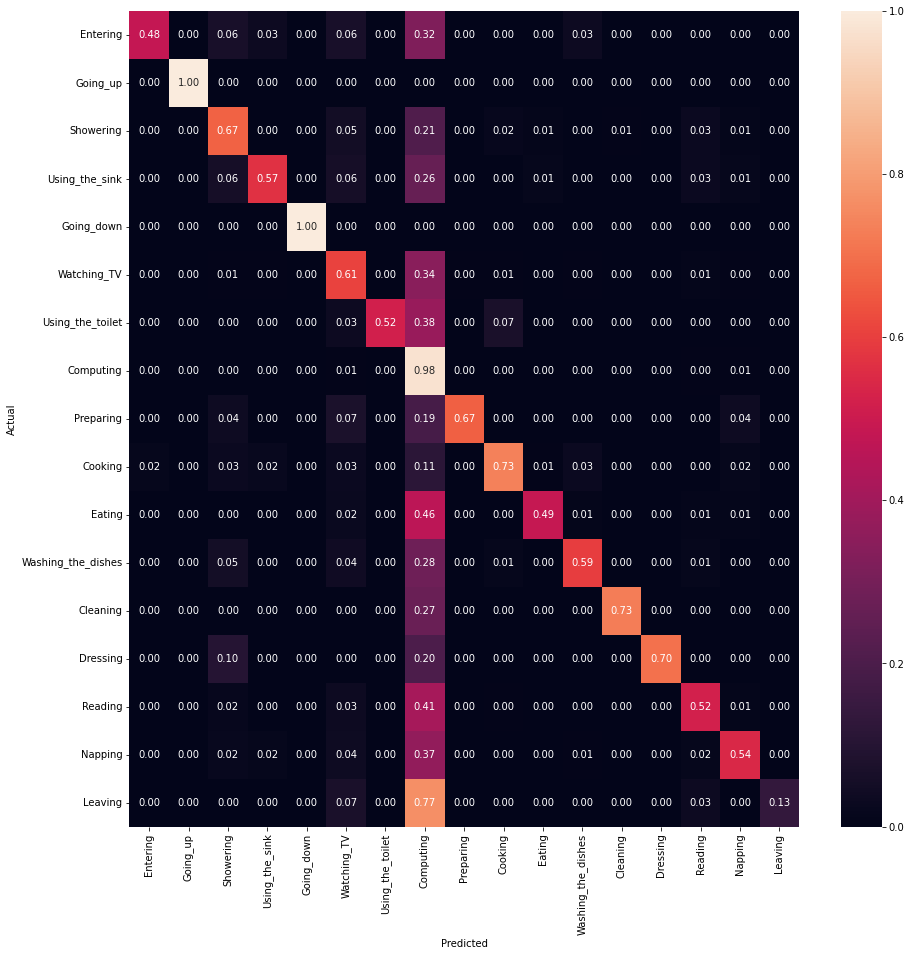

In [15]:
import seaborn as sns

cm = confusion_matrix(testy.argmax(axis=1), predictions.argmax(axis=1))

# cm = confusion_matrix(
#     LABELSActivity[testy.argmax(axis=1)],
#     LABELSActivity[predictions.argmax(axis=1)],
#     labels = LABELSActivity,
# )
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=LABELSActivity, yticklabels=LABELSActivity)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)